# Imports

In [248]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score,recall_score, precision_score

import ast

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

# Path and Load Data 

In [3]:
data = pd.read_csv('sport_[actual_size=4829]_processed_merge.csv').sport
data = pd.DataFrame(data=data)
data.head() 

,sport
0,"['mike', 'bossi', 'one', ""hockey'"", 'prolif', ..."
1,"['jacki', 'robinson', 'way', '🙌', 'jacki', '42..."
2,"['jame', 'harden', 'show', 'postseason', 'disc..."
3,"['clipper', 'star', 'paul', 'georg', 'enter', ..."
4,"['ring', 'bell', 'time', 'ye', 'tough', '7', '..."


In [4]:
INTEREST_positive_tweets = data[:4968] 
print('INTEREST tweets size :', len(INTEREST_positive_tweets))
INTEREST_negative_tweets = data[4968:] 
print('non-INTEREST tweets size :', len(INTEREST_negative_tweets))

INTEREST tweets size : 4968
non-INTEREST tweets size : 4861


* Train test split: 20% will be in the test set, and 80% in the training set.


In [5]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = INTEREST_positive_tweets[4000:]
train_pos = INTEREST_positive_tweets[:4000]

test_neg = INTEREST_negative_tweets[4000:]
train_neg = INTEREST_negative_tweets[:4000]

In [6]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [7]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [8]:
print('train shaoe:', train_y.shape)
print('test shape:', test_y.shape)

train shaoe: (8000, 1)
test shape: (1829, 1)


# Vocabulary for Politics Dataset 

In [9]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [10]:
train_x_arr = generate_tweets_list(train_x)

In [11]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [12]:
freqs = build_freqs(train_x_arr, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [13]:
len(freqs)

14445

In [238]:
freqs_vis = np.ndarray((1,2))

for (word, label), value in freqs.items(): 
    if label == 1.0: 
        freqs_vis = np.append(freqs_vis, [[word, value]], axis=0)

        
freqs_vis

array([['6.95249042283253e-310', '6.95249042283253e-310'],
       ['mike', '27'],
       ['bossi', '2'],
       ...,
       ['👌', '1'],
       ['out', '1'],
       ['calhoun', '1']], dtype='<U32')

In [239]:
freqs_vis = np.delete(freqs_vis, 0, axis=0)

In [240]:
freqs_vis = pd.DataFrame(data=freqs_vis, columns=['word', 'frequency'])
freqs_vis.head()

,word,frequency
0,mike,27
1,bossi,2
2,one,146
3,hockey',3
4,prolif,1


In [246]:
freqs_vis['frequency'] = freqs_vis['frequency'].astype('int')
freqs_vis = freqs_vis.nlargest(columns='frequency', n=20).iloc[2:,:]
freqs_vis

,word,frequency
124,first,322
70,…,306
257,win,250
104,year,228
95,espn,214
125,season,211
341,‼,193
97,coach,186
82,team,179
1384,🔥,174


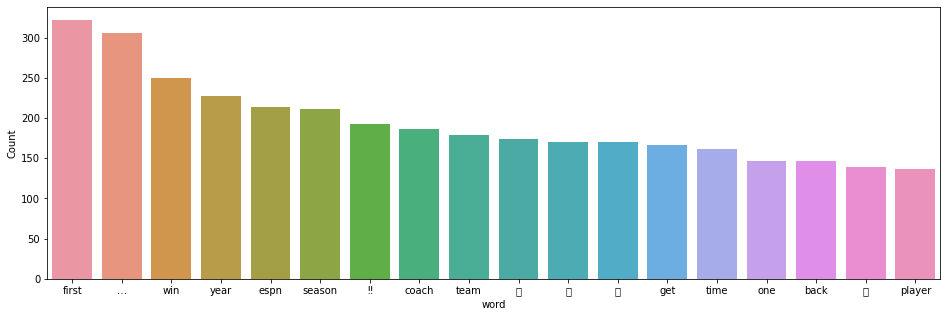

In [247]:
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=freqs_vis, x='word', y='frequency')
ax.set(ylabel = 'Count') 
plt.show() 

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [14]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [15]:
# Ex 
train_x_arr[0]

['mike',
 'bossi',
 'one',
 "hockey'",
 'prolif',
 'goal',
 'scorer',
 'star',
 'island',
 '1980',
 'dynasti',
 'die',
 'age',
 '65']

In [16]:
extract_features(train_x_arr[0], freqs)

array([[  1., 347., 360.]])

In [17]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [18]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[1.000e+00, 3.470e+02, 3.600e+02],
       [1.000e+00, 5.560e+02, 1.200e+02],
       [1.000e+00, 1.528e+03, 7.320e+02],
       [1.000e+00, 9.720e+02, 7.110e+02],
       [1.000e+00, 7.680e+02, 7.400e+02]])

In [19]:
y = train_y

In [20]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [21]:
X

array([[1.000e+00, 1.490e+02, 2.310e+02],
       [1.000e+00, 2.530e+02, 7.200e+01],
       [1.000e+00, 1.700e+02, 3.640e+02],
       ...,
       [1.000e+00, 1.093e+03, 2.790e+02],
       [1.000e+00, 1.354e+03, 1.410e+02],
       [1.000e+00, 3.440e+02, 1.240e+02]])

In [22]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,149.0,231.0,1.0
1,1.0,253.0,72.0,1.0
2,1.0,170.0,364.0,0.0
3,1.0,817.0,46.0,1.0
4,1.0,965.0,206.0,1.0


<Figure size 720x720 with 0 Axes>

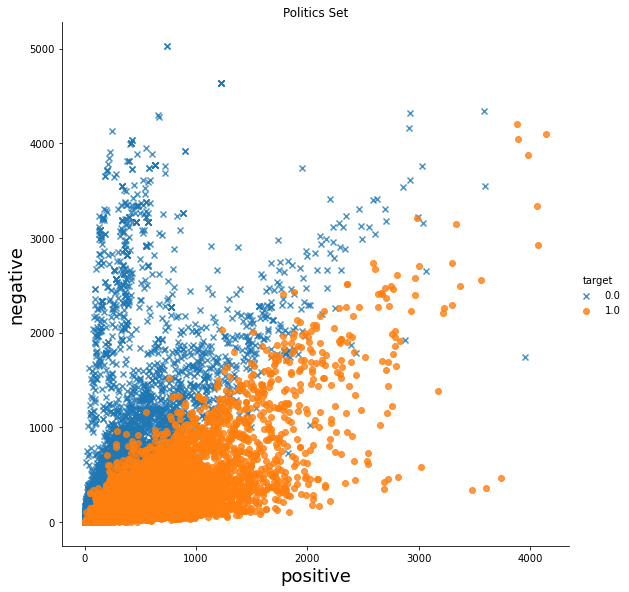

In [23]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [24]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.91125 , 0.915625, 0.903125, 0.906875, 0.910625])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [25]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

Wall time: 259 ms


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='accuracy')

In [27]:
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.909375
Best Hyperparameters: {'C': 0.001}


In [28]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003790,0.000384,0.000804,0.000402,0.0,{'C': 1e-10},0.850625,0.850625,0.841875,0.850000,0.850000,0.848625,0.003387,9
1,0.005586,0.000788,0.000605,0.000494,0.00001,{'C': 1e-05},0.911250,0.915000,0.903125,0.906250,0.910625,0.909250,0.004134,7
2,0.004987,0.000630,0.000397,0.000486,0.0001,{'C': 0.0001},0.911250,0.915000,0.903125,0.905625,0.911250,0.909250,0.004283,7
3,0.004788,0.000399,0.000399,0.000489,0.001,{'C': 0.001},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1
4,0.004588,0.000489,0.000599,0.000489,0.01,{'C': 0.01},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1
5,0.004787,0.000399,0.000200,0.000400,0.1,{'C': 0.1},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1
6,0.004395,0.000483,0.000599,0.000489,1,{'C': 1},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1
7,0.004785,0.000397,0.000593,0.000485,10,{'C': 10},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1
8,0.004787,0.000399,0.000606,0.000495,100,{'C': 100},0.911250,0.915000,0.903750,0.905625,0.911250,0.909375,0.004108,1


In [64]:
search.best_score_

0.909375

# Test Logistic Regression Model

In [29]:
test_x_arr = generate_tweets_list(test_x)

In [30]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[  1., 783., 762.],
       [  1.,  61.,  16.],
       [  1., 815., 610.],
       [  1., 698.,  91.],
       [  1., 926., 711.]])

In [31]:
search.best_estimator_.score(X_test, test_y.ravel())

0.7495899398578458

In [32]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.7545551982851018


In [133]:
y_hat = search.best_estimator_.predict(X_test)
print("Precision is", precision_score(test_y.ravel(), y_hat))

Precision is 0.7839643652561247


In [134]:
y_hat = search.best_estimator_.predict(X_test)
print("Recall is", recall_score(test_y.ravel(), y_hat))

Recall is 0.7272727272727273


# Classifier 2 : SVM 

In [33]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [34]:
clf_svm.score(X_test, test_y.ravel())

0.761071623838163

In [35]:
clf_svm.score(X, y.ravel())

0.909

In [36]:
clf_svm.coef0

0.0

In [38]:
clf_svm.coef_

array([[-6.75299816e-11,  9.29230553e-03, -8.48942928e-03]])

# 2.1 Cross-Validation on Simple SVM Model 

In [39]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.90625 , 0.913125, 0.904375, 0.90625 , 0.911875])

# 2.2 SVM Grid Search on Linear Kernel 

In [40]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.905 total time=   0.5s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.914 total time=   0.4s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.904 total time=   0.4s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.907 total time=   0.4s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.912 total time=   0.5s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.905 total time=   0.6s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.914 total time=   0.7s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.904 total time=   0.6s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.907 total time=   0.8s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.912 total time=   0.7s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.905 total time=   1.7s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [41]:
grid_svm_linear.best_score_

0.908625

In [42]:
grid_svm_linear.best_estimator_

SVC(C=0.1, kernel='linear')

In [43]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.762165117550574

In [44]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.7613823368074603

In [135]:
recall_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.8116959064327486

In [136]:
precision_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.7169421487603306

In [137]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7545551982851018,
        'precision':0.7839643652561247 , 
        'recall': 0.7272727272727273,
        'test accuracy' : 0.7495899398578458,
        'validation accuracy': 0.909375 
    },
    
    'Linear SVM': {
        'f1 score': 0.7613823368074603, 
        'precision':0.7169421487603306, 
        'recall':0.8116959064327486,
        'test accuracy':  0.762165117550574,
        'validation accuracy': 0.908625
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.754555,0.761382
precision,0.783964,0.716942
recall,0.727273,0.811696
test accuracy,0.749590,0.762165
validation accuracy,0.909375,0.908625


# 2.3 Grid Search on SVM RBF Kernel 

In [46]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svm_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid_svm_rbf.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   5.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.504 total time=   7.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.504 total time=   6.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.506 total time=   8.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=   6.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.509 total time=   7.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.514 total time=   6.7s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.511 total time=   6.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.509 total time=   6.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.507 total time=   6.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.708 total time=   8.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.564 total time=   6.2s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.570 total time=   6.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.563 total time=   5.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.575 total time=   5.3s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.683 total time=   5.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.688 total time=   5.3s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.686 total time=   6.2s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.664 total time=   6.3s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.691 total time=   5.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.785 total time=   5.3s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.776 total time=   8.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.807 total time=   8.8s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [47]:
grid_svm_rbf.best_score_

0.90575

In [48]:
grid_svm_rbf.best_estimator_.score(X_test, test_y.ravel())

0.7561509021323127

In [49]:
f1_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7573449401523396

In [138]:
precision_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.71900826446281

In [139]:
recall_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.8

In [140]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7545551982851018,
        'precision':0.7839643652561247 , 
        'recall': 0.7272727272727273,
        'test accuracy' : 0.7495899398578458,
        'validation accuracy': 0.909375 
    },
    
    'Linear SVM': {
        'f1 score': 0.7613823368074603, 
        'precision':0.7169421487603306, 
        'recall':0.8116959064327486,
        'test accuracy':  0.762165117550574,
        'validation accuracy': 0.908625
    },
    
    'RBF SVM' : {
        'f1 score': 0.7573449401523396, 
        'precision':0.71900826446281 ,
        'recall': 0.8,
        'test accuracy': 0.7573449401523396,
        'validation accuracy': 0.90575
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM
f1 score,0.754555,0.761382,0.757345
precision,0.783964,0.716942,0.719008
recall,0.727273,0.811696,0.800000
test accuracy,0.749590,0.762165,0.757345
validation accuracy,0.909375,0.908625,0.905750


# 3. Naive Bayes Classifier 

In [51]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    result = dict() 
    
    for y, tweet in zip(ys, tweets):
        for word in tweet:
          
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
   
    return result

In [52]:
freqs = count_tweets(train_x_arr, train_y.squeeze())

In [53]:
freqs

{('mike', 1.0): 27,
 ('bossi', 1.0): 2,
 ('one', 1.0): 146,
 ("hockey'", 1.0): 3,
 ('prolif', 1.0): 1,
 ('goal', 1.0): 65,
 ('scorer', 1.0): 11,
 ('star', 1.0): 51,
 ('island', 1.0): 4,
 ('1980', 1.0): 4,
 ('dynasti', 1.0): 1,
 ('die', 1.0): 18,
 ('age', 1.0): 11,
 ('65', 1.0): 3,
 ('jacki', 1.0): 15,
 ('robinson', 1.0): 17,
 ('way', 1.0): 44,
 ('🙌', 1.0): 83,
 ('42', 1.0): 6,
 ('via', 1.0): 376,
 ('jame', 1.0): 47,
 ('harden', 1.0): 25,
 ('show', 1.0): 51,
 ('postseason', 1.0): 10,
 ('discuss', 1.0): 75,
 ('nba', 1.0): 128,
 ('playoff', 1.0): 90,
 ('warrior', 1.0): 36,
 ('still', 1.0): 39,
 ('titl', 1.0): 91,
 ('contend', 1.0): 4,
 ('kyler', 1.0): 9,
 ('murray', 1.0): 11,
 ('get', 1.0): 167,
 ('want', 1.0): 39,
 ('cardin', 1.0): 23,
 ('latest', 1.0): 46,
 ('⤵', 1.0): 44,
 ('️', 1.0): 593,
 ('clipper', 1.0): 15,
 ('paul', 1.0): 16,
 ('georg', 1.0): 6,
 ('enter', 1.0): 21,
 ("league'", 1.0): 6,
 ('health', 1.0): 7,
 ('safeti', 1.0): 9,
 ('protocol', 1.0): 6,
 ('miss', 1.0): 38,
 ("tonig

In [54]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [55]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [56]:
logprior, loglikelihood = train_naive_bayes(freqs=freqs, train_x=train_x_arr, train_y=train_y.squeeze())

In [57]:
logprior

0.0

In [58]:
loglikelihood

{'win-win': -1.2301565166439823,
 'rook': 0.8492850250358536,
 'teresagiudic': -0.5370093360840371,
 'mania': -0.5370093360840371,
 'inquiri': -0.5370093360840371,
 'warriors-lak': 0.8492850250358536,
 'opposit': -0.7601528873982469,
 'payton': 1.9478973137039635,
 'hack': -2.328768805312092,
 'smell': -0.5370093360840371,
 'epa': -0.5370093360840371,
 'referr': -1.2301565166439823,
 'dig': -1.4533000679581922,
 'mini-controversi': -0.5370093360840371,
 'recip': -3.5451641296365852,
 'kennard': 0.8492850250358536,
 'richest': -0.9424744441922014,
 "cawthorn'": -0.5370093360840371,
 'file': -0.9889944598270942,
 'grill-out': -0.5370093360840371,
 'backer': -0.5370093360840371,
 'moodi': -0.5370093360840371,
 'depart': -0.6323195158883619,
 'no-equip': -0.5370093360840371,
 'cc': 1.254750133144018,
 'iq': -0.5370093360840371,
 'co-creat': -0.5370093360840371,
 'hole': 1.254750133144018,
 'feloni': -1.4533000679581922,
 'coachella-them': -0.5370093360840371,
 '98': -0.9424744441922014,
 '

## p = logprior + sum_i(loglikelihood_i)

In [59]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a processed tweet
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [60]:
tweet = train_x_arr[0]
p = naive_bayes_predict(tweet, logprior, loglikelihood) 
p

12.328890371091772

In [61]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error
    
    return accuracy

In [62]:
test_naive_bayes(test_x_arr, test_y.squeeze(), logprior, loglikelihood) 

0.833242208857299

In [69]:
test_naive_bayes(train_x_arr, np.squeeze(train_y), logprior, loglikelihood)

0.986625

In [146]:
y_hats =[naive_bayes_predict(item, logprior, loglikelihood) > 0 if 1 else 0 for item in test_x_arr]

In [147]:
f1_score(np.squeeze(test_y), y_hats)

0.8364611260053619

In [148]:
precision_score(np.squeeze(test_y), y_hats)

0.8695652173913043

In [149]:
recall_score(np.squeeze(test_y), y_hats)

0.8057851239669421

In [150]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7545551982851018,
        'precision':0.7839643652561247 , 
        'recall': 0.7272727272727273,
        'test accuracy' : 0.7495899398578458,
        'validation accuracy': 0.909375 
    },
    
    'Linear SVM': {
        'f1 score': 0.7613823368074603, 
        'precision':0.7169421487603306, 
        'recall':0.8116959064327486,
        'test accuracy':  0.762165117550574,
        'validation accuracy': 0.908625
    },
    
    'RBF SVM' : {
        'f1 score': 0.7573449401523396, 
        'precision':0.71900826446281 ,
        'recall': 0.8,
        'test accuracy': 0.7573449401523396,
        'validation accuracy': 0.90575
    },
    
    'Naive Bayes' : {
        'f1 score': 0.8364611260053619, 
        'precision':0.8695652173913043, 
        'recall': 0.8057851239669421,
        'test accuracy': 0.833242208857299,
        'validation accuracy': 0.986625 
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM,Naive Bayes
f1 score,0.754555,0.761382,0.757345,0.836461
precision,0.783964,0.716942,0.719008,0.869565
recall,0.727273,0.811696,0.800000,0.805785
test accuracy,0.749590,0.762165,0.757345,0.833242
validation accuracy,0.909375,0.908625,0.905750,0.986625


# Implemenet Naive Bayes With Sklearn 

In [71]:
from sklearn.naive_bayes import MultinomialNB

In [76]:
train_x_non_array = [' '.join(item) for item in train_x_arr] 
train_x_non_array[:5] 

["mike bossi one hockey' prolif goal scorer star island 1980 dynasti die age 65",
 'jacki robinson way 🙌 jacki 42 via',
 'jame harden show postseason discuss nba playoff warrior still titl contend kyler murray get want cardin latest ⤵ ️',
 "clipper star paul georg enter league' health safeti protocol miss tonight' play-in game vs new orlean sourc tell",
 'ring bell time ye tough 7 month super hear dr brown say zero cancer …']

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
vectorizer = CountVectorizer() 

In [107]:
vectorizer.fit(train_x_non_array)

CountVectorizer()

In [109]:
train_x_for_naivebayes = vectorizer.transform(train_x_non_array)

In [85]:
len(train_x_arr)

8000

In [93]:
len(vectorizer.vocabulary_)

10301

In [112]:
classifier_nb = MultinomialNB()

In [113]:
classifier_nb.fit(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

MultinomialNB()

In [115]:
classifier_nb.score(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

0.979

In [119]:
test_x_non_array = [' '.join(item) for item in test_x_arr] 
test_x_non_array[:5]

['philli fan gave alec bohm ovat make routin play third 😅 made two error right play',
 'taijuan walker nasti pitch strike bryce harper 💯',
 'wast time tonight 3-0 earli vs philli mark canha continu hot start new york 🔥',
 '2,990 career hit miggi 👏 via',
 'angel make postseason year first time sinc 2014']

In [120]:
text_x_vectorized = vectorizer.transform(test_x_non_array)

In [123]:
classifier_nb.score(text_x_vectorized, np.squeeze(test_y))

0.8130125751776928

In [124]:
model_nb = (logprior, loglikelihood)

# Save The Best Model 

## Pickle 

It allows you to serialize your python object into a file.

In [125]:
with open('sport_naivebayes.', 'wb') as f: 
    pickle.dump(model_nb, f)

In [126]:
with open('sport_naivebayes.', 'rb') as f: 
    model_pickle = pickle.load(f)

In [127]:
type(model_pickle)

tuple

In [129]:
(logprior, loglikelihood) = model_pickle

In [130]:
logprior

0.0

In [131]:
loglikelihood

{'win-win': -1.2301565166439823,
 'rook': 0.8492850250358536,
 'teresagiudic': -0.5370093360840371,
 'mania': -0.5370093360840371,
 'inquiri': -0.5370093360840371,
 'warriors-lak': 0.8492850250358536,
 'opposit': -0.7601528873982469,
 'payton': 1.9478973137039635,
 'hack': -2.328768805312092,
 'smell': -0.5370093360840371,
 'epa': -0.5370093360840371,
 'referr': -1.2301565166439823,
 'dig': -1.4533000679581922,
 'mini-controversi': -0.5370093360840371,
 'recip': -3.5451641296365852,
 'kennard': 0.8492850250358536,
 'richest': -0.9424744441922014,
 "cawthorn'": -0.5370093360840371,
 'file': -0.9889944598270942,
 'grill-out': -0.5370093360840371,
 'backer': -0.5370093360840371,
 'moodi': -0.5370093360840371,
 'depart': -0.6323195158883619,
 'no-equip': -0.5370093360840371,
 'cc': 1.254750133144018,
 'iq': -0.5370093360840371,
 'co-creat': -0.5370093360840371,
 'hole': 1.254750133144018,
 'feloni': -1.4533000679581922,
 'coachella-them': -0.5370093360840371,
 '98': -0.9424744441922014,
 '